In [1]:
!pip install dalex

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 19.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for dalex: filename=dalex-1.7.0-py3-none-any.whl size=1042471 sha256=708a416159bc6bd421030cdb30d8bec25635fca781d43a7a092461216de23b2d
  Stored in directory: /root/.cache/pip/wheels/e2/38/c1/25a95206a4873a287d776fc8e77aa7d93971acc643ecb3db38
Successfully built dalex


In [2]:
#Importing necessary libraries
import sklearn.metrics as metrics
import datetime
import re
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import seaborn as sns
import math
from urllib.parse import urlparse
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [3]:
#To display all the columns and rows
pd.set_option('display.max_columns', 1000);
pd.set_option('display.max_rows', 1000);
pd.set_option('display.width', 1000);
#To ignore warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
#To supress scientific notations
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [4]:
#Importing the file
df = pd.read_excel("/content/drive/MyDrive/Capstone_Project/Backup/de_sa_2021_2022.xlsx")

In [5]:
X = df.drop(['TARGET_ABUSER'], axis=1)
y = df['TARGET_ABUSER']
#Oversampling using SMOTE
from collections import Counter
from imblearn.over_sampling import SMOTE
#current class distribution
print(Counter(y))
# define oversample strategy
sm = SMOTE(random_state=42)
# fit and apply the transform
Xsm, ysm = sm.fit_resample(X,y)
# summarize class distribution after oversampling
print(Counter(ysm))

Counter({0: 25193, 1: 5867})
Counter({0: 25193, 1: 25193})


In [6]:
#Importing the data so as to use the same data with every run
X_train = pd.read_excel("/content/drive/MyDrive/Capstone_Project/Backup/X_train.xlsx")
y_train = pd.read_excel("/content/drive/MyDrive/Capstone_Project/Backup/y_train.xlsx")
X_test = pd.read_excel("/content/drive/MyDrive/Capstone_Project/Backup/X_test.xlsx")
y_test = pd.read_excel("/content/drive/MyDrive/Capstone_Project/Backup/y_test.xlsx")

In [7]:
X_test.rename(columns={'Unnamed: 0': 'Index'}, inplace=True)
X_train.rename(columns={'Unnamed: 0': 'Index'}, inplace=True)
y_test.rename(columns={'Unnamed: 0': 'Index'}, inplace=True)
y_train.rename(columns={'Unnamed: 0': 'Index'}, inplace=True)

In [8]:
X_test.set_index('Index', inplace=True)
X_train.set_index('Index', inplace=True)
y_test.set_index('Index', inplace=True)
y_train.set_index('Index', inplace=True)

In [9]:
y_train = y_train.TARGET_ABUSER
y_test = y_test.TARGET_ABUSER

Classification Report : 
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      5010
           1       0.88      0.82      0.85      5068

    accuracy                           0.86     10078
   macro avg       0.86      0.86      0.86     10078
weighted avg       0.86      0.86      0.86     10078

Area Under the Curve 0.8564148734890126
Confusion Matrix : 
[[4459  551]
 [ 898 4170]]


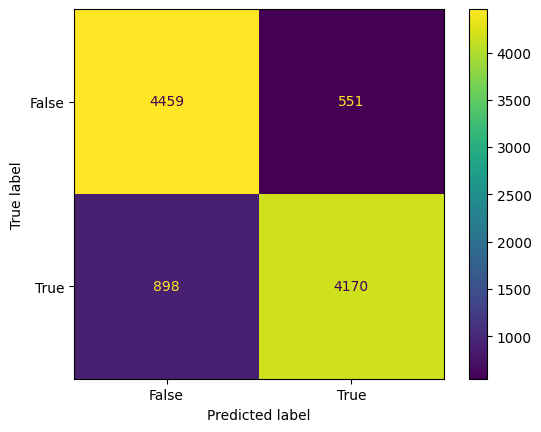

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
rf = RandomForestClassifier(n_estimators=400, random_state=32)
# fiting the model to data
rf.fit(X_train, y_train)
#print(rf.score(X_train,y_train))
y_pred_rf = rf.predict(X_test)
clf_report = classification_report(y_test, y_pred_rf)
print(f"Classification Report : \n{clf_report}")
#calculate AUC of model
auc = metrics.roc_auc_score(y_test, y_pred_rf)
#print AUC score
print('Area Under the Curve',auc)
#printing the confusion matrix
confusion_matrix = metrics.confusion_matrix(y_test, y_pred_rf)
print(f"Confusion Matrix : \n{confusion_matrix}")
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

In [11]:
import dalex as dx

In [12]:
exp = dx.Explainer(rf, X, y)

Preparation of a new explainer is initiated

  -> data              : 31060 rows 47 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 31060 values
  -> model_class       : sklearn.ensemble._forest.RandomForestClassifier (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_proba_default at 0x7b39e4c27be0> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.0, mean = 0.248, max = 1.0
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.988, mean = -0.0591, max = 0.98
  -> model_info        : package sklearn

A new explainer has been created!


In [13]:
# Because you are running the model on X and y not X_test and y_test hence performance is different
exp.model_performance().result

,recall,precision,f1,accuracy,auc
RandomForestClassifier,0.869,0.901,0.885,0.957,0.980


In [14]:
exp.model_parts().plot()

In [15]:
protected = df.SEX
privileged = '1'

In [16]:
fobject = exp.model_fairness(protected = protected, privileged= privileged)

In [17]:
fobject.fairness_check(epsilon = 0.8) # default epsilon

Bias detected in 2 metrics: FPR, STP

Conclusion: your model is not fair because 2 or more criteria exceeded acceptable limits set by epsilon.

Ratios of metrics, based on '1'. Parameter 'epsilon' was set to 0.8 and therefore metrics should be within (0.8, 1.25)
    TPR   ACC   PPV   FPR   STP
2 0.939 1.035 1.102 0.136 0.471


In [18]:
# to see all scaled metric values you can run
fobject.result

,TPR,TNR,PPV,NPV,FNR,FPR,FDR,FOR,ACC,STP
1,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000
2,0.939,1.040,1.102,1.011,1.491,0.136,0.321,0.703,1.035,0.471


In [19]:
# or unscaled ones via
fobject.metric_scores

,TPR,TNR,PPV,NPV,FNR,FPR,FDR,FOR,ACC,STP
1,0.890,0.956,0.869,0.963,0.110,0.044,0.131,0.037,0.939,0.255
2,0.836,0.994,0.958,0.974,0.164,0.006,0.042,0.026,0.972,0.120


In [20]:
fobject.plot(type = 'metric_scores')

In [21]:
fobject.plot()

In [22]:
fobject.plot(type = "radar")

In [23]:
fobject.plot(type = "heatmap")

In [24]:
fobject.plot(type = "stacked")

In [25]:
fobject.plot(type = "performance_and_fairness")

Dropping the biased features from the dataset

In [26]:
df = df.drop(columns=['SEX','AGE','RACE'],axis=1)

In [27]:
df.shape

(31060, 45)

In [28]:
#Separating the dataframe
X = df.drop(columns=['TARGET_ABUSER'])  # Features
y = df['TARGET_ABUSER']  # Target variable
#Oversampling using SMOTE
from collections import Counter
from imblearn.over_sampling import SMOTE
#current class distribution
print(Counter(y))
# define oversample strategy
sm = SMOTE(random_state=42)
# fit and apply the transform
X, y = sm.fit_resample(X,y)
# summarize class distribution after oversampling
print(Counter(y))
#Splitting the data set into 75% training and 25% testing
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

Counter({0: 25193, 1: 5867})
Counter({0: 25193, 1: 25193})


0.9999735372727513
Classification Report : 
              precision    recall  f1-score   support

           0       0.81      0.88      0.84      6343
           1       0.86      0.79      0.83      6254

    accuracy                           0.84     12597
   macro avg       0.84      0.84      0.84     12597
weighted avg       0.84      0.84      0.84     12597

Area Under the Curve 0.8360193729520912
Confusion Matrix : 
[[5564  779]
 [1283 4971]]


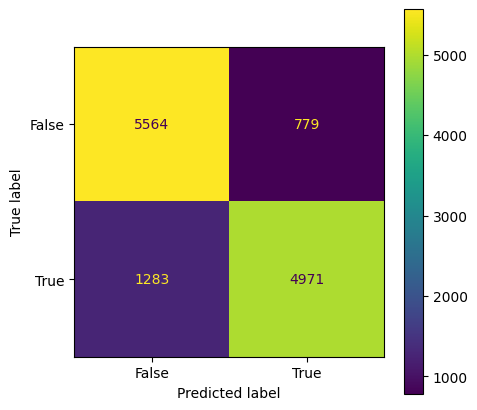

In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
rf = RandomForestClassifier()
plt.rcParams["figure.figsize"] = (5,5)
# fiting the model to data
rf.fit(X_train, y_train)
print(rf.score(X_train,y_train))
y_pred_rf = rf.predict(X_test)
clf_report = classification_report(y_test, y_pred_rf)
print(f"Classification Report : \n{clf_report}")
#calculate AUC of model
auc = metrics.roc_auc_score(y_test, y_pred_rf)
#print AUC score
print('Area Under the Curve',auc)
#printing the confusion matrix
confusion_matrix = metrics.confusion_matrix(y_test, y_pred_rf)
print(f"Confusion Matrix : \n{confusion_matrix}")
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

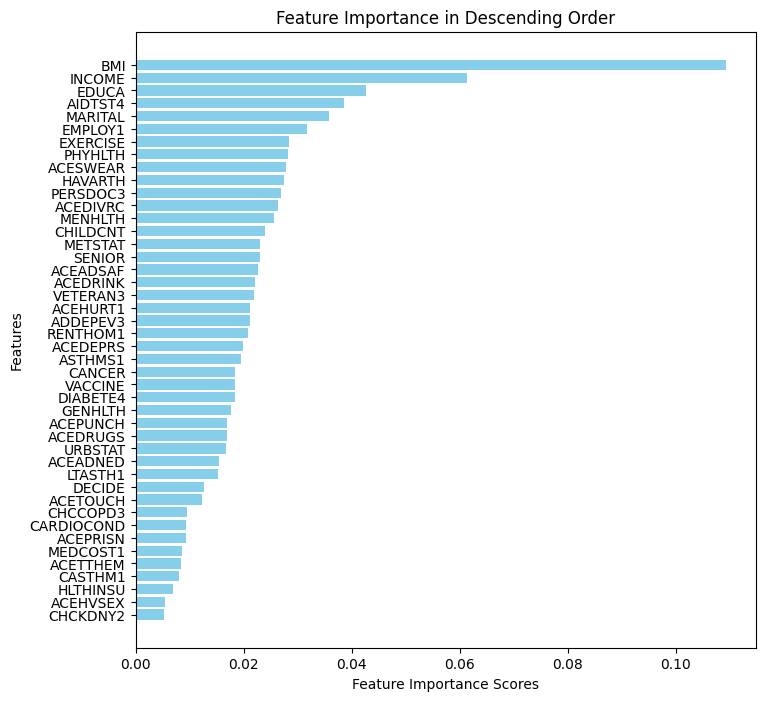

In [30]:
# get feature importance
feature_importances = rf.feature_importances_
plt.rcParams["figure.figsize"] = (8,8)
# Get feature names
feature_names = X.columns.tolist()
# Sort the feature importances and feature names in descending order
sorted_indices = np.argsort(feature_importances)
sorted_feature_importances = [feature_importances[i] for i in sorted_indices]
sorted_feature_names = [feature_names[i] for i in sorted_indices]
# Plot the horizontal bar chart for feature importance
plt.barh(sorted_feature_names, sorted_feature_importances, color='skyblue')
plt.xlabel('Feature Importance Scores')
plt.ylabel('Features')
plt.title('Feature Importance in Descending Order')
plt.show()

In [31]:
exp_post = dx.Explainer(rf, X, y)

Preparation of a new explainer is initiated

  -> data              : 50386 rows 44 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 50386 values
  -> model_class       : sklearn.ensemble._forest.RandomForestClassifier (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_proba_default at 0x7b39e4c27be0> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.0, mean = 0.51, max = 1.0
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.99, mean = -0.0102, max = 0.98
  -> model_info        : package sklearn

A new explainer has been created!


In [35]:
exp_post.model_performance().result

,recall,precision,f1,accuracy,auc
RandomForestClassifier,0.951,0.966,0.958,0.959,0.990


In [33]:
exp_post.model_parts().plot()